# House price prediction using Deep Neural Network

Đây là đồ án cuối khóa cho lớp Machine Learning Hanoi 2019 (ML101-HN) tổ chức bởi VEF Alumni.

Đề tài đồ án: Xây dựng mô hình dự đoán giá nhà sử dụng tệp dữ liệu giá nhà Ames trên Kaggle.

Kỹ thuật sử dụng trong mô hình là mạng deep neural network phát triển trên platform keras.

Phần EDA dựa trên tutorial của TA Trần Đức Tân. Phần mạng deep neural network dựa trên hướng dẫn của Mohammed Ma'amari trên trang Towards Data Science.



##Importing some needed library

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt

##Uploading the Ames Housing datasets

In [0]:
from google.colab import files

uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
train = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
print('Shape of training data:', train.shape)
print('Shape of testing data:', test.shape)

Shape of training data: (1460, 81)
Shape of testing data: (1459, 80)


Tệp dữ liệu Ames Housing gồm 2 tệp: tệp train và tệp test.

Tệp train gồm 1460 điểm dữ liệu với 81 features, trong đó có 2 features đặc biệt:

*  **Id**
*  **SalePrice**

Tệp test chỉ có 80 feature do chưa có feature SalePrice, đây là target cần dự đoán.

79 features chia thành 2 loại dữ liệu: dữ liệu dạng numerical và dữ liệu dạng categorial

In [0]:
numerical = [f for f in train.columns if train.dtypes[f] != 'object']
numerical.remove('SalePrice')
numerical.remove('Id')
categorical = [f for f in train.columns if train.dtypes[f] == 'object']
print('- Numerical attributes (%d) :' % len(numerical))
print(numerical)
print('- Categorical attributes (%d) :' % len(categorical))
print(categorical)

- Numerical attributes (36) :
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
- Categorical attributes (43) :
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Firepl

##Finding the columns that have missing values

In [0]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


Tổng cộng 19 features thiếu dữ liệu. Những features thiếu quá nhiều dữ liệu sẽ bị loại bỏ. Các features thiếu ít có thể điền đầy bằng *median*.

##Correlation between the features

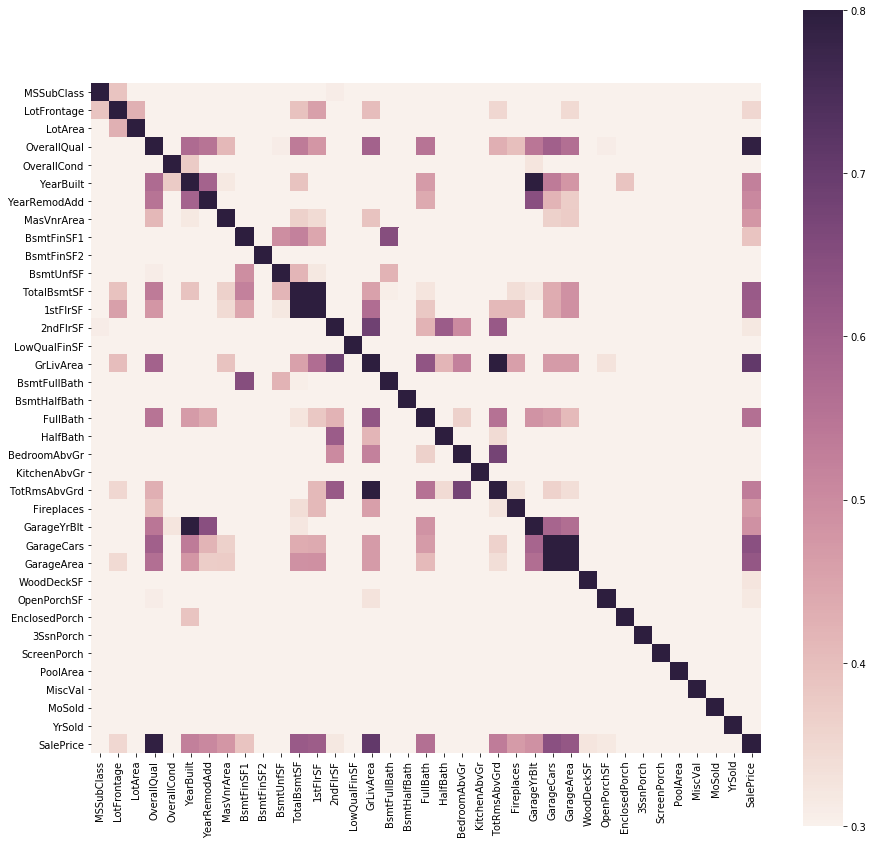

In [0]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
train_encoded = train.copy()
for q in categorical:  
    encode(train_encoded, q)
    qual_encoded.append(q + '_E')
qual_encoded.append('SalePrice')

cmap = sb.cubehelix_palette(light = 0.95, as_cmap = True)
plt.figure(figsize = (15, 15))
sb.heatmap(abs(train.drop(['Id'], axis=1).corr(method = 'pearson')), vmin = 0.3,vmax = 0.8, square = True, cmap = cmap)

Có thể đưa ra một số kết luận sau:
Có khoảng 15 features liên quan mạng tới giá nhà bao gồm:
1. LotFrontage

2. **OverallQual**

3. YearBuilt

4. YearRemoveAdd

5. MasVnArea

6. BsmtFinSF1

7. TotalBsmtSF

8. 1stFlrSF

9. GrLivArea

10. FullBath

11. TotRmsAbvGrd

12. Fireplaces

13. GarageYrBlt

14. GarageCars

15. GarageArea

Ngoài ra,

YearBuilt và YearRemoveAdd liên quan đến nhau -> chỉ sử dụng **YearBuilt**

YearBuilt và GarageYrBlt liên quan đến nhau -> chỉ sử dụng **YearBuilt**

TotRmsAbvGrd và GrLivArea liên quan đến nhau -> chỉ sử dụng **GrLivArea**

TotalBsmtSF và 1stFlrSF liên quan đến nhau -> chỉ sử dụng **TotalBsmtSF**

Các features về garage liên quan đến nhau -> chỉ sử dụng **GarageArea**

LotFrontage thiếu nhiều dữ liệu nhưng có liên quan đến LotArea -> sử dụng **LotArea**

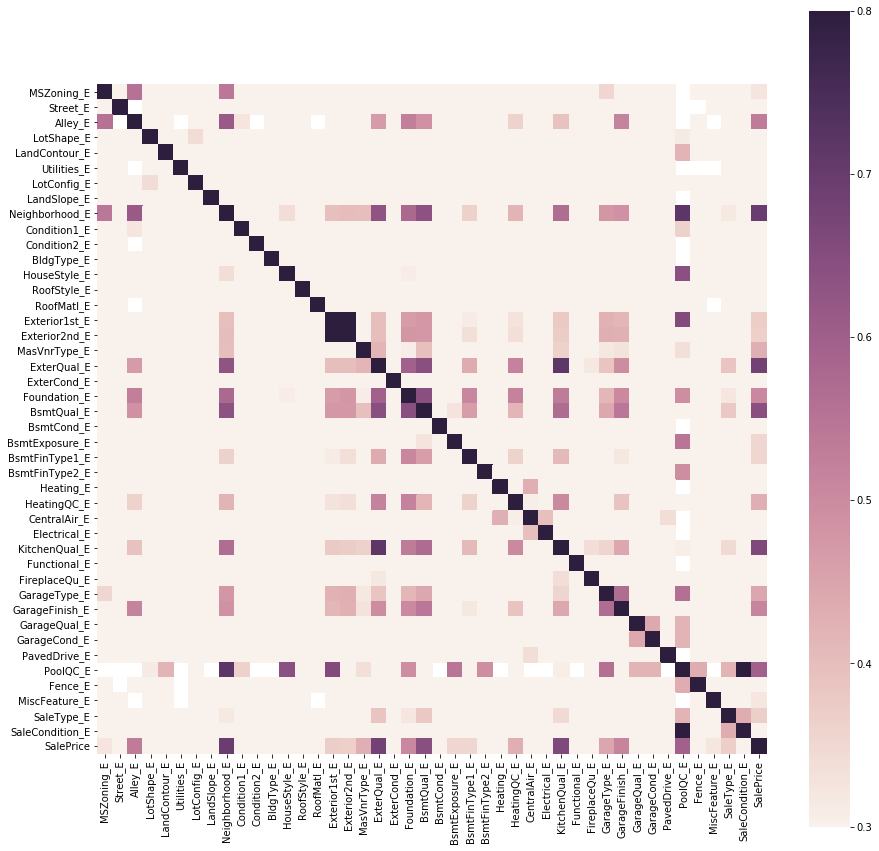

In [0]:
plt.figure(figsize = (15, 15))
sb.heatmap(abs(train_encoded[qual_encoded].corr(method = 'pearson')), vmin = 0.3,vmax = 0.8, square = True, cmap = cmap)

Có khoảng 15 features liên quan mạng tới giá nhà bao gồm:

1. Alley -> thiếu nhiều dữ liệu nên bỏ

2. **Neightborhood**

3. **ExterQual**

4. MasVnrType

5. **Foundation**

6. BsmtQual

7. **HeatingQC**

8. **KitchenQual**

9. GarageType

10. GarageFinish

11. PoolQC -> do dữ liệu thiếu nhiều nên cần thay thế bằng feature khác tương đương


##Feature Engineering

In [0]:
numerical_features = ['OverallQual','LotArea', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'GarageArea']
categorical_features = [ 'Neighborhood', 'ExterQual','Foundation','HeatingQC','KitchenQual']
bool_features = ['IsNew', 'HasPool']
target = 'SalePrice'

train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

X = pd.get_dummies(train[numerical_features + categorical_features + bool_features])
y = train[target]

print('Shape of training features:', X.shape)
print('Shape of training target:', y.shape)

Shape of training features: (1460, 52)
Shape of training target: (1460,)


##Built a Deep Neural Network


* Define a sequential model
* Add some dense layers
* Use 'relu' as the activation function in the hidden layers
* Use a 'normal' initializer as the kernal_intializer
* Using mean_absolute_error as a loss function
* Define the output layer with only one node
* Use 'linear 'as the activation function for the output layer

In [0]:
NN_model = Sequential()
NN_model.add(Dense(128,kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               6784      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 171,649
Trainable params: 171,649
Non-trainable params: 0
_________________________________________________________________


In [0]:
#checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
#checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
#callbacks_list = [checkpoint]

In [0]:
NN_model.fit(X, y, epochs=500, batch_size=32, validation_split = 0.2)

Train on 1168 samples, validate on 292 samples
Epoch 1/500
1168/1168 [==============================] - 1s 458us/step - loss: 133680.3964 - mean_absolute_error: 133680.3964 - val_loss: 57655.1330 - val_mean_absolute_error: 57655.1330
Epoch 2/500
1168/1168 [==============================] - 0s 121us/step - loss: 59310.4356 - mean_absolute_error: 59310.4356 - val_loss: 49885.2135 - val_mean_absolute_error: 49885.2135
Epoch 3/500
1168/1168 [==============================] - 0s 118us/step - loss: 46852.5933 - mean_absolute_error: 46852.5933 - val_loss: 40258.2417 - val_mean_absolute_error: 40258.2417
Epoch 4/500
1168/1168 [==============================] - 0s 117us/step - loss: 38546.9012 - mean_absolute_error: 38546.9012 - val_loss: 40992.9401 - val_mean_absolute_error: 40992.9401
Epoch 5/500
1168/1168 [==============================] - 0s 127us/step - loss: 35361.0343 - mean_absolute_error: 35361.0343 - val_loss: 35570.7544 - val_mean_absolute_error: 35570.7544
Epoch 6/500
1168/1168 [===

In [0]:
test['IsNew'] = test['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)
test['HasPool'] = test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

testX = pd.get_dummies(test[numerical_features + categorical_features + bool_features])
print('Shape of testing features:', testX.shape)

Shape of testing features: (1459, 52)


In [0]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':pd.read_csv('test.csv').Id,'SalePrice':prediction})
  my_submission['SalePrice']=my_submission['SalePrice'].fillna(my_submission['SalePrice'].mean())
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  total = my_submission.isnull().sum().sort_values(ascending=False)
  percent = (my_submission.isnull().sum() / my_submission.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  missing_data.head(5)
  print('A submission file has been made')
  print(missing_data)

predictions = NN_model.predict(testX)

make_submission(predictions[:,0],'submission(NN)')



A submission file has been made
           Total  Percent
SalePrice      0      0.0
Id             0      0.0
